In [1]:
import torch_geometric


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import torch
from gmn_lim.model_arch_graph import graph_to_arch, arch_to_sequential, feats_to_arch

In [3]:

def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)



In [4]:
cnns_dir = 'data/cnn_hpo'

train_losses_all = []
val_losses_all = []
accuracies = []
hyperparams_all = []
epoch0_graphs = []
for i,dirname in enumerate(os.listdir(cnns_dir)):
    if os.path.isdir(os.path.join(cnns_dir, dirname)):
        cnn_dir = os.path.join(cnns_dir, dirname)
        if i < 50:
            epoch0_graph = torch.load(os.path.join(cnn_dir, 'epoch_0_feats.pt'))
            epoch0_graphs.append(epoch0_graph)
        results = load_json(os.path.join(cnn_dir, 'results.json'))
        train_losses = results['train_losses']
        val_losses = results['val_losses']
        accuracy = results['accuracy']
        hyperparams = results['hyperparameters']
        train_losses_all.append(train_losses)
        val_losses_all.append(val_losses)
        accuracies.append(accuracy)
        hyperparams_all.append(hyperparams)

In [5]:
EDGE_TYPES = {
    "lin_weight": 0,
    "lin_bias": 1,
    "conv_weight": 2,
    "conv_bias": 3,
    "residual": 4,
    "bn_gamma": 5,
    "bn_beta": 6,
    "ln_gamma": 7,
    "ln_beta": 8,
    "gn_gamma": 9,
    "gn_beta": 10,
    "in_gamma": 11,
    "in_beta": 12,
    "triplanar": 13,
}
NUM_TO_EDGE_TYPE = {v: k for k, v in EDGE_TYPES.items()}

num_conv_params 40480
num_lin_params 970
num_conv_params 24880
num_lin_params 3498
num_conv_params 14768
num_lin_params 3306
num_conv_params 93248
num_lin_params 9642
num_conv_params 31312
num_lin_params 1210
num_conv_params 47136
num_lin_params 4458
num_conv_params 75648
num_lin_params 13066
num_conv_params 24352
num_lin_params 874
num_conv_params 5520
num_lin_params 442
num_conv_params 20304
num_lin_params 26122
num_conv_params 21328
num_lin_params 17802
num_conv_params 111680
num_lin_params 2410
num_conv_params 166592
num_lin_params 8906
num_conv_params 77376
num_lin_params 2778
num_conv_params 10144
num_lin_params 698
num_conv_params 149440
num_lin_params 1482
num_conv_params 40480
num_lin_params 2762
num_conv_params 185472
num_lin_params 17802
num_conv_params 40592
num_lin_params 17802
num_conv_params 40480
num_lin_params 970
num_conv_params 40480
num_lin_params 698
num_conv_params 19392
num_lin_params 698
num_conv_params 12048
num_lin_params 9610
num_conv_params 24080
num_lin_par

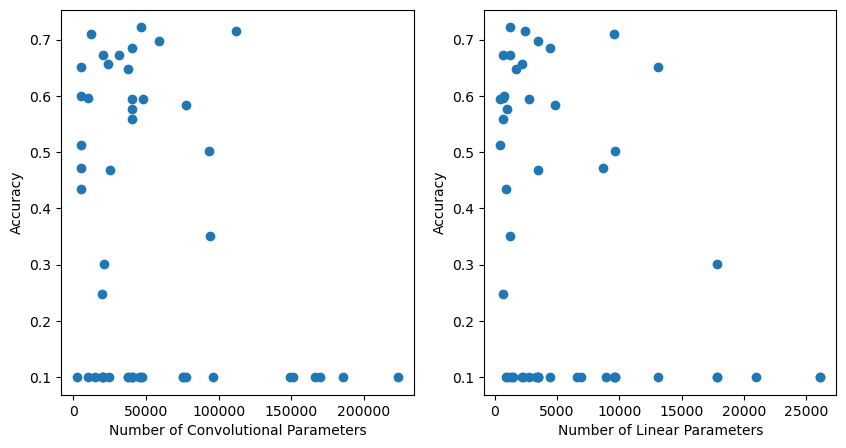

In [34]:

num_conv_param_counts = []
num_lin_param_counts = []
highest_conv_param_count=0
highest_conv_param_count_model=None
for i, param_graph in enumerate(epoch0_graphs):
    num_conv_params = 0
    num_lin_params = 0
    node_feats, edge_index, edge_feats = param_graph
    num_conv_params += np.sum(np.where(edge_feats[:,2] == EDGE_TYPES["conv_weight"], 1, 0))
    num_conv_params += np.sum(np.where(edge_feats[:,2] == EDGE_TYPES["conv_bias"], 1, 0))
    num_lin_params += np.sum(np.where(edge_feats[:,2] == EDGE_TYPES["lin_weight"], 1, 0))
    num_lin_params += np.sum(np.where(edge_feats[:,2] == EDGE_TYPES["lin_bias"], 1, 0))
    num_conv_param_counts.append(num_conv_params)
    num_lin_param_counts.append(num_lin_params)
    print("num_conv_params", num_conv_params)
    print("num_lin_params", num_lin_params)

    if num_conv_params > highest_conv_param_count:
        highest_conv_param_count = num_conv_params
        highest_conv_param_count_model = i

# plot conv params and lin params vs accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(num_conv_param_counts, accuracies[:len(num_conv_param_counts)])
ax[0].set_xlabel('Number of Convolutional Parameters')
ax[0].set_ylabel('Accuracy')
ax[1].scatter(num_lin_param_counts, accuracies[:len(num_lin_param_counts)])
ax[1].set_xlabel('Number of Linear Parameters')
ax[1].set_ylabel('Accuracy')
plt.show()


In [35]:

NODE_TYPES = {
    "neuron": 0,
    "bias": 1,
    "channel": 2,
    "channel_bias": 3,
    "bn_gamma": 4,
    "bn_beta": 5,
    "ln_gamma": 6,
    "ln_beta": 7,
    "gn_gamma": 8,
    "gn_beta": 9,
    "in_gamma": 10,
    "in_beta": 11,
    "attention_neuron": 12,
    "attention_bias": 13,
    "deepsets_neuron": 14,
    "deepsets_bias": 15,
    "triplanar": 16,
}
NUM_TO_NODE_TYPE = {v: k for k, v in NODE_TYPES.items()}

In [36]:
test_param_graph = epoch0_graphs[highest_conv_param_count_model]
node_feats, edge_index, edge_feats = test_param_graph
layers_seen= set()
layers={'conv': 0, 'lin': 0}
edges_per_layer = {}
for i in range(node_feats.shape[0]):
    node_feat = node_feats[i].tolist()
    #print(node_feat)
    layer_num = node_feat[0]
    if layer_num in layers_seen:
        continue  
    layers_seen.add(layer_num) 
    node_type = node_feat[2]
    node_type = NUM_TO_NODE_TYPE[node_type]
    if node_type == 'channel':
        layers['conv'] += 1
    elif node_type == 'neuron':
        layers['lin'] += 1

for layer_num in layers_seen:
    edges_per_layer[layer_num] = np.sum(np.where(edge_feats[:, 1] == layer_num, 1, 0))
    # for edge_feat in edge_feats:
    #     layer_num = edge_feat[1].item()
    #     if layer_num not in edges_per_layer:
    #         edges_per_layer[layer_num] = 0
    #     edges_per_layer[int(layer_num)] +=1
    
print(layers)

print(edges_per_layer)
layers_seen

{'conv': 4, 'lin': 3}
{0: 1792, 1: 73984, 2: 147840, 3: 4640, 4: 4224, 5: 1290, 6: 0}


{0, 1, 2, 3, 4, 5, 6}

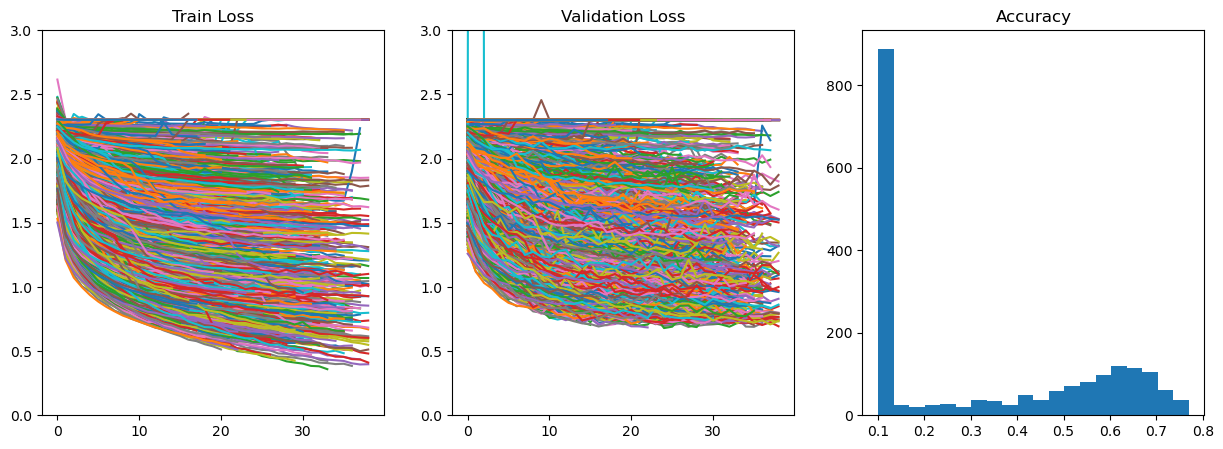

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for train_losses, val_losses in zip(train_losses_all, val_losses_all):
    ax[0].plot(train_losses)
    ax[1].plot(val_losses)

# histogram of accuracies
ax[2].hist(accuracies, bins=20)




ax[0].set_ylim(0, 3)
ax[0].set_title('Train Loss')
ax[1].set_ylim(0, 3)
ax[1].set_title('Validation Loss')
ax[2].set_title('Accuracy')
plt.show()

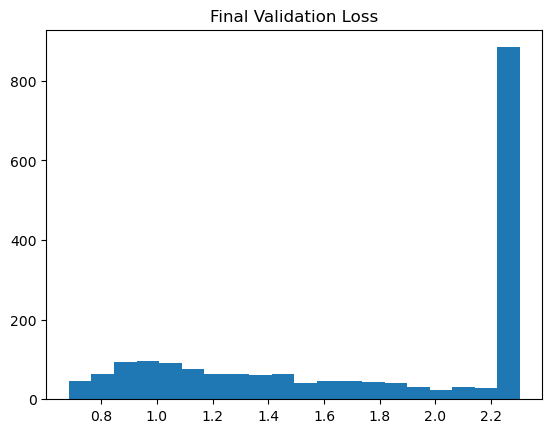

In [8]:
# final val loss histogram
final_val_losses = [val_losses[-1] for val_losses in val_losses_all]
plt.hist(final_val_losses, bins=20)
plt.title('Final Validation Loss')
plt.show()

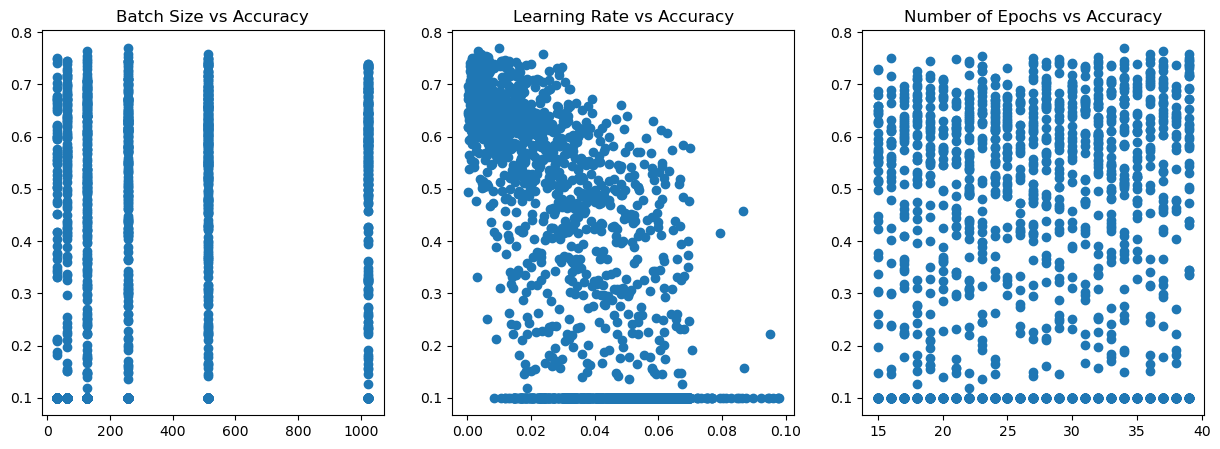

In [9]:
# correlation between hyperparameters and accuracy
# [batch_size, lr, n_epochs, momentum
hyperparams_all = np.array(hyperparams_all)
accuracies = np.array(accuracies)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(hyperparams_all[:, 0], accuracies)
ax[0].set_title('Batch Size vs Accuracy')
ax[1].scatter(hyperparams_all[:, 1], accuracies)
ax[1].set_title('Learning Rate vs Accuracy')
ax[2].scatter(hyperparams_all[:, 2], accuracies)
ax[2].set_title('Number of Epochs vs Accuracy')

plt.show()